In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir(r'/content/gdrive/MyDrive/SBC22_IQA_dataset')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
src_path = "/content/gdrive/MyDrive/SBC22_IQA_dataset"

path_2_train_csv = os.path.join(src_path, 'train.csv')
train_df = pd.read_csv(path_2_train_csv)
path_2_test_csv = os.path.join(src_path, 'sample_submission.csv') # В sample_submission хранятся имена файлов тестовой выборки
test_df = pd.read_csv(path_2_test_csv)

In [ ]:
imgs = []
for img_name in tqdm(train_df.img_name.values, total=len(train_df)):
    img = cv2.imread(os.path.join(src_path, 'train', img_name))
    imgs.append(img)

  0%|          | 0/13210 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
imgs = np.array(imgs)

In [ ]:
img.shape

(480, 640, 3)

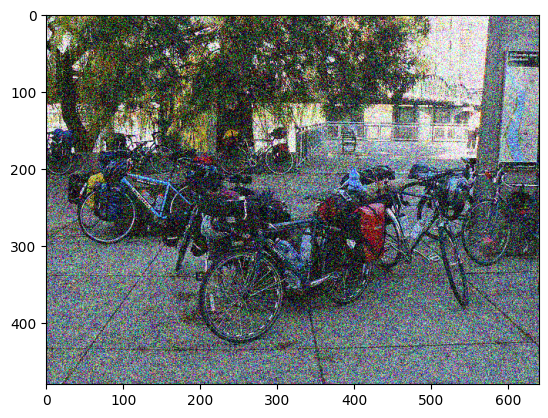

In [ ]:
# посмотрим на содержание
ind = np.random.randint(0, len(imgs))
plt.imshow(cv2.cvtColor(imgs[ind], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Получение названий референсных картинок
ref_names = set()
for img_name in train_df.img_name.values:
    ref_names.add(img_name.split('_')[0])
ref_names = sorted(list(ref_names))
np.random.seed(7)
np.random.shuffle(ref_names)

In [ ]:
train_df = train_df.iloc[:len(imgs)]

In [ ]:
# Деление на train и val
train_size = 0.8

train_names = []
train_ids = []
val_names = []
val_ids = []
for i, img_name in enumerate(train_df.img_name.values):
    ref = img_name.split('_')[0]
    if ref in ref_names[:int(train_size * len(ref_names))]:
        train_names.append(img_name)
        train_ids.append(i)
    else:
        val_names.append(img_name)
        val_ids.append(i)
print(f"Train size: {len(train_names)}")
print(f"Validation size: {len(val_names)}")

Train size: 2508
Validation size: 590


In [ ]:
tr_df = train_df.set_index('img_name').loc[train_names]
val_df = train_df.set_index('img_name').loc[val_names]

In [ ]:
def brightness(img): # яркость
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv[..., 2].mean() / 255

def contrast(img): # контраст
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv[..., 2].std() / 225

def saturation(img): # насыщенность
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv[..., 2].std().mean() / 225

def sharpness_grad_based(img):
    gradx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    grady = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    grad = np.sqrt(gradx * gradx + grady * grady)
    return grad[1: -1, 1: -1].mean()
###################################################################
def get_iqa_fv(img):
    fv = np.empty((0,))
    fv = np.append(fv, brightness(img))
    fv = np.append(fv, sharpness_grad_based(img))
    fv = np.append(fv, contrast(img))
    fv = np.append(fv, saturation(img))
    return fv

def get_features(list_of_imgs):
    features =[]
    for img in tqdm(list_of_imgs):
        features.append(get_iqa_fv(img))
    features = np.vstack(list(features))
    return features

In [ ]:
print('Подсчет признаков обучающей выборки...')
X_train = get_features(imgs[train_ids])
print('Подсчет признаков валидационной выборки...')
X_val = get_features(imgs[val_ids])
X_train.shape, X_val.shape

Подсчет признаков обучающей выборки...


  0%|          | 0/2508 [00:00<?, ?it/s]

Подсчет признаков валидационной выборки...


  0%|          | 0/590 [00:00<?, ?it/s]

((2508, 4), (590, 4))

In [ ]:
y_train = tr_df.PSNR.values
y_val = val_df.PSNR.values

In [ ]:
test_imgs = []
for img_name in tqdm(test_df.img_name.values, total=len(test_df)):
    img = cv2.imread(os.path.join(src_path, 'test', img_name))
    test_imgs.append(img)

test_imgs = np.array(test_imgs)

  0%|          | 0/3310 [00:00<?, ?it/s]

# Линейная регрессия

In [ ]:
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)

In [ ]:
def rrmse(y_pred, y_val):
    return np.sqrt(mean_squared_error(y_pred, y_val) / np.sum(pow(y_val, 2))) * 100

In [ ]:
# print(f'rrmse = {rrmse(y_pred, y_val)}')
# print(f'mae = {mean_absolute_error(y_pred, y_val)}')

In [ ]:
# Обучение на всей выборке

names = []
ids = []

for i, img_name in enumerate(train_df.img_name.values):
    ref = img_name.split('_')[0]
    names.append(img_name)
    ids.append(i)

print(f"Train size: {len(names)}")
print(f"Validation size: {len(ids)}")

Train size: 3098
Validation size: 3098


In [ ]:
df = train_df.set_index('img_name').loc[names]
arg = get_features(test_imgs)

  0%|          | 0/3310 [00:00<?, ?it/s]

In [ ]:
x = get_features(imgs[ids])

  0%|          | 0/3098 [00:00<?, ?it/s]

In [ ]:
y = df.PSNR.values

In [ ]:
# model.fit(x, y)

In [ ]:
# res = model.predict(arg)

In [ ]:
#pd.DataFrame(res, columns=['PSNR']).to_csv(r'/content/gdrive/MyDrive/Нефть/predict.csv')

# Полиномиальная регрессия

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)

poly_features = poly.fit_transform(X_train)
poly_features_test = poly.fit_transform(X_val)

poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)

y_pred_1 = poly_reg_model.predict(poly_features_test)

In [ ]:
print(f'rrmse = {rrmse(y_pred_1, y_val)}')
print(f'mae = {mean_absolute_error(y_pred_1, y_val)}')

rrmse = 0.23449702239400805
mae = 0.8896522293812915


In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)

#reshape data to work properly with sklearn
poly_features = poly.fit_transform(x)

#fit polynomial regression model
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)

LinearRegression()

In [ ]:
result = poly_reg_model.predict(poly.fit_transform(arg))

In [ ]:
result

In [ ]:
#pd.DataFrame(result, columns=['PSNR']).to_csv(r'/content/gdrive/MyDrive/Нефть/predict2.csv')